# Iterative Corpus Refinement for Materials Property Prediction Based on Scientific Texts

In [3]:
!python -m ipykernel install --user --name=venv --display-name "Python (venv)"

import pandas as pd
import sys
from pathlib import Path
# Add parent directory of the notebook to sys.path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))
from MatNexus import PaperCollector, TextProcessor, VecGenerator, VecVisualizer
import plotly.io as py
from sklearn.metrics.pairwise import cosine_similarity
import os
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Doc2Vec, Word2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from pathlib import Path
import re
nltk.download('punkt')

Installed kernelspec venv in C:\Users\doaam\AppData\Roaming\jupyter\kernels\venv


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\doaam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\doaam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\doaam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!



🔁 Iteration 1
📚 Word2Vec vocab size after iteration 1: 1798
🧩 Centroid vector: [0.98341334 0.91273   ]
→ First centroid calculated.

🔁 Iteration 2
📚 Word2Vec vocab size after iteration 2: 2690
🧩 Centroid vector: [0.9722066 0.946951 ]
→ Centroid shift: 0.0360

🔁 Iteration 3
📚 Word2Vec vocab size after iteration 3: 3439
🧩 Centroid vector: [0.94668865 0.96707416]
→ Centroid shift: 0.0325

🔁 Iteration 4
📚 Word2Vec vocab size after iteration 4: 3982
🧩 Centroid vector: [0.8734119  0.91681904]
→ Centroid shift: 0.0889

🔁 Iteration 5
📚 Word2Vec vocab size after iteration 5: 4510
🧩 Centroid vector: [0.7343925  0.75709015]
→ Centroid shift: 0.2118

🔁 Iteration 6
📚 Word2Vec vocab size after iteration 6: 5036
🧩 Centroid vector: [0.55164605 0.6669375 ]
→ Centroid shift: 0.2038

🔁 Iteration 7
📚 Word2Vec vocab size after iteration 7: 5492
🧩 Centroid vector: [0.5433774 0.5682155]
→ Centroid shift: 0.0991

🔁 Iteration 8
📚 Word2Vec vocab size after iteration 8: 5856
🧩 Centroid vector: [0.39972055 0.504

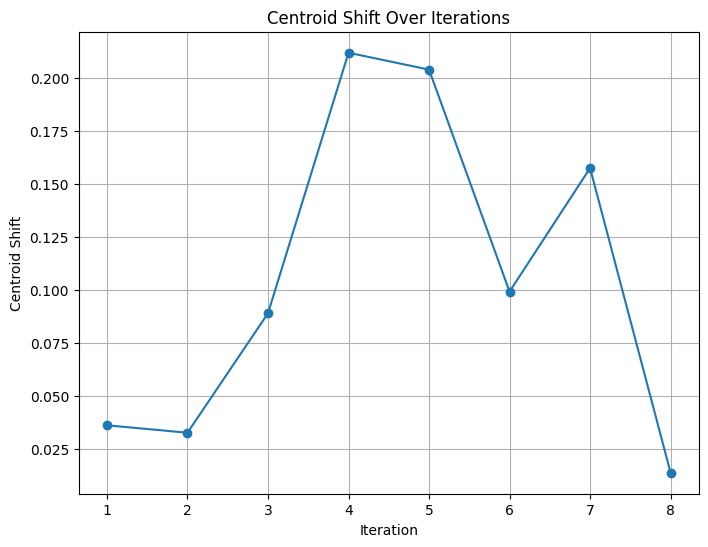

In [ ]:
# Load your corpus
df = pd.read_csv('processed_file_new.csv')

# Prepare tagged documents
documents = [
    TaggedDocument(words=word_tokenize(str(text).lower()), tags=[i])
    for i, text in enumerate(df['abstract']) if pd.notnull(text)
]

# Train Doc2Vec model (200D)
doc2vec = Doc2Vec(documents, vector_size=200, window=5, min_count=2, epochs=40, workers=4, dm=1)
doc_vectors = np.array([doc2vec.dv[i] for i in range(len(documents))])

# Reduce to 2D using PCA
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(doc_vectors)

# Greedy farthest-point selection
def greedy_selection(embeddings, selected_indices, batch_size=50):
    n = len(embeddings)
    remaining_indices = list(set(range(n)) - set(selected_indices))

    new_batch = []
    if not selected_indices:
        center = np.mean(embeddings, axis=0)
        start_idx = np.argmin(np.linalg.norm(embeddings - center, axis=1))
        new_batch.append(start_idx)
        remaining_indices.remove(start_idx)

    while len(new_batch) < batch_size and remaining_indices:
        dists = [
            min(cosine(embeddings[i], embeddings[j]) for j in selected_indices + new_batch)
            for i in remaining_indices
        ]
        next_idx = remaining_indices[np.argmax(dists)]
        new_batch.append(next_idx)
        remaining_indices.remove(next_idx)

    return new_batch

# Parse composition string like "Ag24.06Au41.19..."
def parse_composition_string(comp_str):
    pattern = r'([A-Z][a-z]*)([0-9.]*)'
    matches = re.findall(pattern, comp_str)
    # If no number provided, assume 1.0
    return {elem.lower(): float(perc) if perc else 1.0 for elem, perc in matches}

# Compute vector for a material composition
def compute_material_vector(model, composition):
    vectors = [
        weight * model.wv[element]
        for element, weight in composition.items()
        if element in model.wv
    ]
    if not vectors:
        return np.zeros(model.vector_size)
    return sum(vectors)

# Compute average similarity to target properties
def compute_centroid_similarity(model, compositions, target_keywords):
    target_vecs = [model.wv[k] for k in target_keywords if k in model.wv]
    if not target_vecs:
        print("No target keywords found in vocabulary.")
        return np.zeros(len(target_keywords))

    all_sims = []
    for comp in compositions:
        vec = compute_material_vector(model, comp)
        if np.linalg.norm(vec) == 0:
            continue
        sim = []
        for t in target_vecs:
            denom = np.linalg.norm(vec) * np.linalg.norm(t)
            sim_val = np.dot(vec, t) / denom if denom != 0 else 0
            sim.append(sim_val)
        all_sims.append(sim)

    if not all_sims:
        return np.zeros(len(target_keywords))

    return np.mean(all_sims, axis=0)

# Define your sample composition (example)
composition_strings = ["AgAuPdPtRu"]
sample_compositions = [parse_composition_string(c) for c in composition_strings]
target_keywords = ['conductivity', 'resistance']

# Initialize
selected_indices = []
prev_centroid = None
centroid_shifts = []
all_centroids = []
convergence_threshold = 0.03
batch_size = 50
max_batches = 20

for iteration in range(max_batches):
    print(f"\n Iteration {iteration + 1}")

    new_batch = greedy_selection(pca_embeddings, selected_indices, batch_size=batch_size)
    selected_indices.extend(new_batch)

    # Prepare selected corpus for Word2Vec
    selected_texts = [
        word_tokenize(str(df.iloc[i]['abstract']).lower())
        for i in selected_indices if pd.notnull(df.iloc[i]['abstract'])
    ]

    word2vec = Word2Vec(sentences=selected_texts, vector_size=200, window=5, min_count=1, sg=1, hs=1, workers=4)

    print(f" Word2Vec vocab size after iteration {iteration+1}: {len(word2vec.wv)}")

    # Check if required tokens exist
    required_tokens = set(target_keywords)
    for comp in sample_compositions:
        required_tokens.update(comp.keys())

    missing_tokens = [tok for tok in required_tokens if tok not in word2vec.wv]
    if missing_tokens:
        print(f" Skipping iteration {iteration+1} due to missing tokens: {missing_tokens}")
        continue

    # Compute centroid
    centroid = compute_centroid_similarity(word2vec, sample_compositions, target_keywords)
    all_centroids.append(centroid)
    print(f"Centroid vector: {centroid}")

    if prev_centroid is not None:
        shift = np.linalg.norm(centroid - prev_centroid)
        centroid_shifts.append(shift)
        print(f"Centroid shift: {shift:.4f}")
        # Force minimum 3 iterations before allowing convergence
        if iteration >= 2 and shift < convergence_threshold:
            print("Converged. Stopping refinement.")
            break
    else:
        print("First centroid calculated.")

    prev_centroid = centroid

# Save results
selected_docs = df.iloc[selected_indices].copy()
selected_docs.to_csv("final_selected_docs.csv", index=False)
pd.DataFrame({'centroid_shift': centroid_shifts}).to_csv("centroid_shifts.csv", index=False)
pd.DataFrame(all_centroids, columns=[f'target_{i}' for i in range(len(target_keywords))]).to_csv("centroids.csv", index=False)

print(f"\nSaved {len(selected_docs)} selected documents to 'final_selected_docs.csv'.")

# Plot centroid shift
plt.figure(figsize=(8,6))
plt.plot(range(1, len(centroid_shifts)+1), centroid_shifts, marker='o')
plt.title("Centroid Shift Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Centroid Shift")
plt.grid(True)
plt.show()
